In [22]:
# Download from Huggingface
!wget -q --show-progress https://huggingface.co/datasets/cayala/cassava/resolve/main/cassava.zip

# Extract to folder
!unzip -q cassava.zip

# Remove the zip file
!rm cassava.zip

# Extract imagery folder
!unzip -q cassava/images.zip -d cassava/images

# Remove imagery zip
!rm cassava/images.zip

cassava.zip         100%[===================>]   2.38G   105MB/s    in 24s     


In [35]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from collections import defaultdict
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import models
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from torchvision.models import ResNet18_Weights

In [24]:
# Read split CSV + create a filepath column
cassava_df = pd.read_csv('cassava/cassava_split.csv')
cassava_df['filepath'] = cassava_df.image_id.apply(lambda x : f'./cassava/images/{x}')
cassava_df.head()

,image_id,label,set,filepath
0,1584105518.jpg,4,train,./cassava/images/1584105518.jpg
1,4020462779.jpg,1,train,./cassava/images/4020462779.jpg
2,3354881630.jpg,1,train,./cassava/images/3354881630.jpg
3,388811074.jpg,4,train,./cassava/images/388811074.jpg
4,4255258797.jpg,3,train,./cassava/images/4255258797.jpg


In [25]:
class CassavaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        x = Image.open(r.filepath).convert('RGB')
        y = torch.tensor(int(r.label), dtype=torch.long) 
                
        if self.transform: x = self.transform(x)
        
        return x, y

In [26]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, df, bs=64, n_workers=2):
        super().__init__()
        
        self.df = df
        self.bs = bs
        self.n_workers = n_workers

        # ImageNet1K validation transforms
        self.transform = transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def setup(self, stage: str):
        self.train_ds = CassavaDataset(self.df.query('set == "train"'), transform=self.transform)
        self.val_ds = CassavaDataset(self.df.query('set == "val"'), transform=self.transform)
        self.test_ds = CassavaDataset(self.df.query('set == "test"'), transform=self.transform)


    def train_dataloader(self): return DataLoader(self.train_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=True)
    def val_dataloader(self): return DataLoader(self.val_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)
    def test_dataloader(self): return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)

In [28]:
dm = CassavaDataModule(cassava_df, bs=64, n_workers=2)
dm.setup(None)
x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [161]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [34]:
pl.seed_everything(seed=42, workers=True)

model = models.resnet18()
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model)

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_from_scratch")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss', mode='min', filename='best_valid_loss', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 1.5887


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 235: 'val_loss' reached 0.94832 (best 0.94832), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.9401
Average training loss for epoch 0: 1.0352


Validation: |                                                                                                 …

Epoch 1, global step 470: 'val_loss' reached 0.87577 (best 0.87577), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.8678
Average training loss for epoch 1: 0.8874


Validation: |                                                                                                 …

Epoch 2, global step 705: 'val_loss' was not in top 1


Average validation loss for epoch 2: 1.0515
Average training loss for epoch 2: 0.8082


Validation: |                                                                                                 …

Epoch 3, global step 940: 'val_loss' reached 0.74098 (best 0.74098), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.7339
Average training loss for epoch 3: 0.7453


Validation: |                                                                                                 …

Epoch 4, global step 1175: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.9705
Average training loss for epoch 4: 0.7038


Validation: |                                                                                                 …

Epoch 5, global step 1410: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.7446
Average training loss for epoch 5: 0.6887


Validation: |                                                                                                 …

Epoch 6, global step 1645: 'val_loss' reached 0.73284 (best 0.73284), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 6: 0.7250
Average training loss for epoch 6: 0.6484


Validation: |                                                                                                 …

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.9645
Average training loss for epoch 7: 0.6305


Validation: |                                                                                                 …

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.7428
Average training loss for epoch 8: 0.6031


Validation: |                                                                                                 …

Epoch 9, global step 2350: 'val_loss' was not in top 1


Average validation loss for epoch 9: 0.8094
Average training loss for epoch 9: 0.5604


`Trainer.fit` stopped: `max_epochs=10` reached.


In [38]:
import matplotlib.pyplot as plt

In [ ]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')

class_labels = list(class_names.values())
cm = confusion_matrix(y_trues, y_hats, labels=torch.arange(5))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [48]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

for param in model.parameters():
    param.requires_grad = False

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model)

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_tl_feature_extractor")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss', mode='min', filename='best_valid_loss', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
2.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 1.3646


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 235: 'val_loss' reached 0.82459 (best 0.82459), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_feature_extractor/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.8215
Average training loss for epoch 0: 0.9071


Validation: |                                                                                                 …

Epoch 1, global step 470: 'val_loss' reached 0.81422 (best 0.81422), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_feature_extractor/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.8108
Average training loss for epoch 1: 0.7581


Validation: |                                                                                                 …

Epoch 2, global step 705: 'val_loss' reached 0.76913 (best 0.76913), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_feature_extractor/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.7671
Average training loss for epoch 2: 0.7303


Validation: |                                                                                                 …

Epoch 3, global step 940: 'val_loss' reached 0.73495 (best 0.73495), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_feature_extractor/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.7320
Average training loss for epoch 3: 0.7064


Validation: |                                                                                                 …

Epoch 4, global step 1175: 'val_loss' reached 0.73372 (best 0.73372), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_feature_extractor/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 0.7303
Average training loss for epoch 4: 0.6992


Validation: |                                                                                                 …

Epoch 5, global step 1410: 'val_loss' reached 0.72629 (best 0.72629), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_feature_extractor/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 5: 0.7238
Average training loss for epoch 5: 0.6920


Validation: |                                                                                                 …

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.7774
Average training loss for epoch 6: 0.6880


Validation: |                                                                                                 …

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.7400
Average training loss for epoch 7: 0.6959


Validation: |                                                                                                 …

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.7629
Average training loss for epoch 8: 0.6819


Validation: |                                                                                                 …

Epoch 9, global step 2350: 'val_loss' was not in top 1


Average validation loss for epoch 9: 0.7290
Average training loss for epoch 9: 0.6675


`Trainer.fit` stopped: `max_epochs=10` reached.


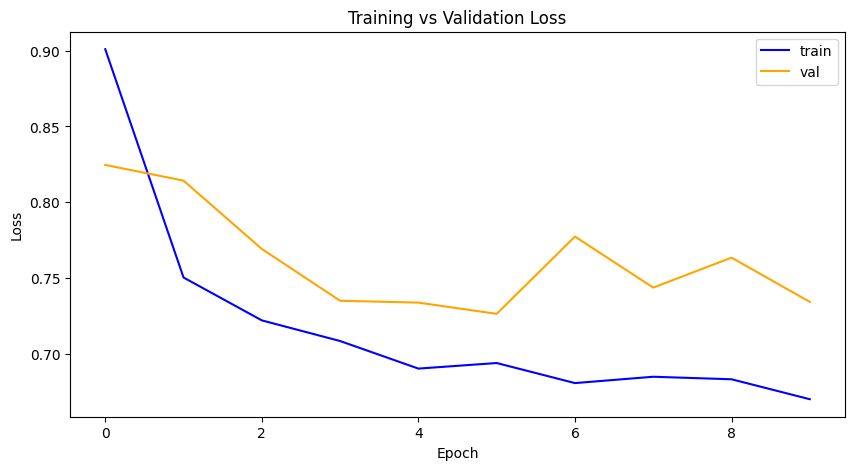

Acc.: 0.7355 | Macro-F1: 0.5435


In [49]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')

# class_labels = list(class_names.values())
# cm = confusion_matrix(y_trues, y_hats, labels=torch.arange(5))

# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()

In [117]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

for param in model.parameters():
    param.requires_grad = False

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model)

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_tl_gradual_unfreezing")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss', mode='min', filename='cassava_tl_gradual_unfreezing', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=5, logger=csv_logger, callbacks=[model_checkpoint_callback])

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
2.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 1.3646


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 235: 'val_loss' reached 0.82459 (best 0.82459), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_gradual_unfreezing/version_0/checkpoints/cassava_tl_gradual_unfreezing.ckpt' as top 1


Average validation loss for epoch 0: 0.8215
Average training loss for epoch 0: 0.9071


Validation: |                                                                                                 …

Epoch 1, global step 470: 'val_loss' reached 0.81422 (best 0.81422), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_gradual_unfreezing/version_0/checkpoints/cassava_tl_gradual_unfreezing.ckpt' as top 1


Average validation loss for epoch 1: 0.8108
Average training loss for epoch 1: 0.7581


Validation: |                                                                                                 …

Epoch 2, global step 705: 'val_loss' reached 0.76913 (best 0.76913), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_gradual_unfreezing/version_0/checkpoints/cassava_tl_gradual_unfreezing.ckpt' as top 1


Average validation loss for epoch 2: 0.7671
Average training loss for epoch 2: 0.7303


Validation: |                                                                                                 …

Epoch 3, global step 940: 'val_loss' reached 0.73495 (best 0.73495), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_gradual_unfreezing/version_0/checkpoints/cassava_tl_gradual_unfreezing.ckpt' as top 1


Average validation loss for epoch 3: 0.7320
Average training loss for epoch 3: 0.7064


Validation: |                                                                                                 …

Epoch 4, global step 1175: 'val_loss' reached 0.73372 (best 0.73372), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_tl_gradual_unfreezing/version_0/checkpoints/cassava_tl_gradual_unfreezing.ckpt' as top 1


Average validation loss for epoch 4: 0.7303
Average training loss for epoch 4: 0.6992


`Trainer.fit` stopped: `max_epochs=5` reached.


In [145]:
from collections import OrderedDict

checkpoint = torch.load(model_checkpoint_callback.best_model_path, map_location='cpu')
state_dict = OrderedDict({k.replace('model.', ''):v for k,v in checkpoint['state_dict'].items()}) # Extract weights from Lightning 'model.conv1.weight' -> 'conv1.weight

lightning_module.model.load_state_dict(state_dict)
lightning_module.lr = 1e-5

# Get the optimizer list from your LightningModule
optimizers = lightning_module.optimizers()  # list
optimizer = optimizers  # assuming only one optimizer

# Load the first optimizer state
optimizer.load_state_dict(checkpoint['optimizer_states'][0])

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5

for param in lightning_module.model.parameters():
    param.requires_grad = True

trainer = pl.Trainer(max_epochs=5, logger=csv_logger, callbacks=[model_checkpoint_callback])

trainer.fit(lightning_module, data_module)

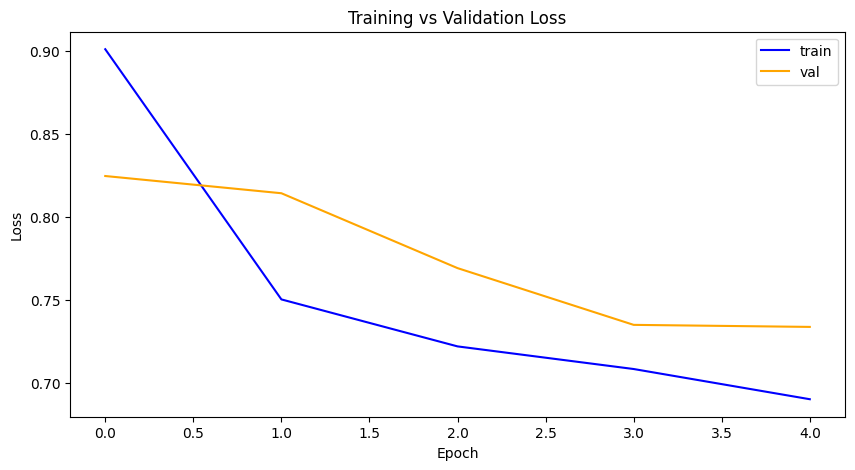

Acc.: 0.7941 | Macro-F1: 0.6422


In [155]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')

In [156]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0., discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):

        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f'{idx}: {name}')
        
        # Reverse layers
        layer_names.reverse()
        
        # placeholder
        parameters      = []
        prev_group_name = layer_names[0].split('.')[0]
        
        # store params & learning rates
        for idx, name in enumerate(layer_names):
            
            # parameter group name
            cur_group_name = name.split('.')[0]
            
            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name
            
            # display info
            print('Using discriminative learning rates')
            print(f'{idx}: lr = {lr:.6f}, {name}')
            
            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                            'lr':     lr}]

        return parameters
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        
        return torch.optim.Adam(
            self.parameters() if self.discriminative_lr == None else self.get_layer_wise_lr(*self.discriminative_lr), 
            lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [157]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model, discriminative_lr=(1e-3, 0.9))

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_ft_disc_lr")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


0: conv1.weight
1: bn1.weight
2: bn1.bias
3: layer1.0.conv1.weight
4: layer1.0.bn1.weight
5: layer1.0.bn1.bias
6: layer1.0.conv2.weight
7: layer1.0.bn2.weight
8: layer1.0.bn2.bias
9: layer1.1.conv1.weight
10: layer1.1.bn1.weight
11: layer1.1.bn1.bias
12: layer1.1.conv2.weight
13: layer1.1.bn2.weight
14: layer1.1.bn2.bias
15: layer2.0.conv1.weight
16: layer2.0.bn1.weight
17: layer2.0.bn1.bias
18: layer2.0.conv2.weight
19: layer2.0.bn2.weight
20: layer2.0.bn2.bias
21: layer2.0.downsample.0.weight
22: layer2.0.downsample.1.weight
23: layer2.0.downsample.1.bias
24: layer2.1.conv1.weight
25: layer2.1.bn1.weight
26: layer2.1.bn1.bias
27: layer2.1.conv2.weight
28: layer2.1.bn2.weight
29: layer2.1.bn2.bias
30: layer3.0.conv1.weight
31: layer3.0.bn1.weight
32: layer3.0.bn1.bias
33: layer3.0.conv2.weight
34: layer3.0.bn2.weight
35: layer3.0.bn2.bias
36: layer3.0.downsample.0.weight
37: layer3.0.downsample.1.weight
38: layer3.0.downsample.1.bias
39: layer3.1.conv1.weight
40: layer3.1.bn1.weight
4

Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 1.3646


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 235: 'val_loss' reached 0.81810 (best 0.81810), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_ft_disc_lr/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.8080
Average training loss for epoch 0: 0.6964


Validation: |                                                                                                 …

Epoch 1, global step 470: 'val_loss' reached 0.73877 (best 0.73877), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_ft_disc_lr/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.7380
Average training loss for epoch 1: 0.5357


Validation: |                                                                                                 …

Epoch 2, global step 705: 'val_loss' was not in top 1


Average validation loss for epoch 2: 1.2682
Average training loss for epoch 2: 0.4514


Validation: |                                                                                                 …

Epoch 3, global step 940: 'val_loss' reached 0.71750 (best 0.71750), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_ft_disc_lr/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.7114
Average training loss for epoch 3: 0.3470


Validation: |                                                                                                 …

Epoch 4, global step 1175: 'val_loss' reached 0.63765 (best 0.63765), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/assignments/p2/cassava_ft_disc_lr/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 0.6281
Average training loss for epoch 4: 0.2955


Validation: |                                                                                                 …

Epoch 5, global step 1410: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.7813
Average training loss for epoch 5: 0.2426


Validation: |                                                                                                 …

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.8057
Average training loss for epoch 6: 0.1789


Validation: |                                                                                                 …

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.8768
Average training loss for epoch 7: 0.1813


Validation: |                                                                                                 …

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.9162
Average training loss for epoch 8: 0.1224


Validation: |                                                                                                 …

Epoch 9, global step 2350: 'val_loss' was not in top 1


Average validation loss for epoch 9: 1.1020
Average training loss for epoch 9: 0.0612


`Trainer.fit` stopped: `max_epochs=10` reached.


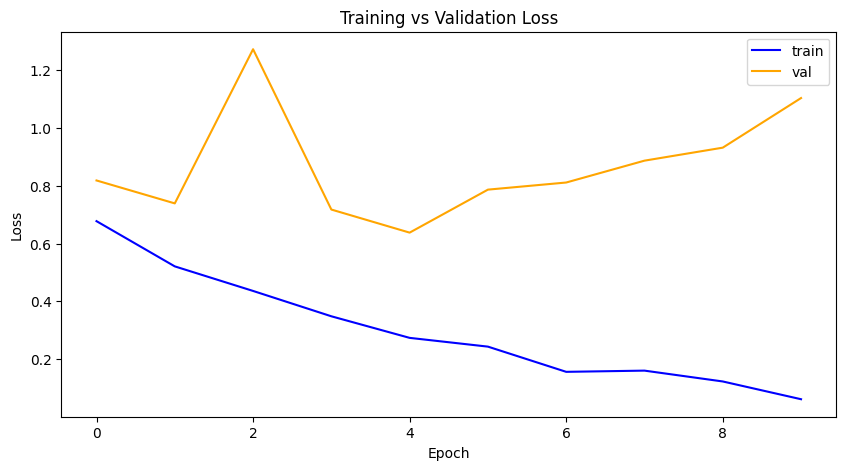

Acc.: 0.8040 | Macro-F1: 0.6708


In [158]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')